<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2024

#### 11220IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import random
from torchsummary import summary


In [2]:
root_dir = "C:\\Users\\AnnaChen\\Python\\DL\\nthu\\hw3\\bottle\\test"
label = ["broken_large", "broken_small", "contamination", "good"]

file_paths = []
for label_dir in label:
    path = os.path.join(root_dir, label_dir) # 合併成完整的資料夾路徑: "C:\Users\AnnaChen\Python\DL\HW1\Dataset\training data\train\disgust")
    img_path = os.listdir(path) # 將該路徑(資料夾)內的圖檔全部讀取到一個List中: ["Training_659019", "Training_680349", ......]
    for img_name in img_path:
        img_item_path = os.path.join(root_dir, label_dir, img_name) # 圖片的路徑: "C:\Users\AnnaChen\Python\DL\HW1\Dataset\training data\train\disgust\Training_659019.jpg"
        file_paths.append(img_item_path)

all_data = []
for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/83 [00:00<?, ?it/s]

(83, 900, 900, 3)


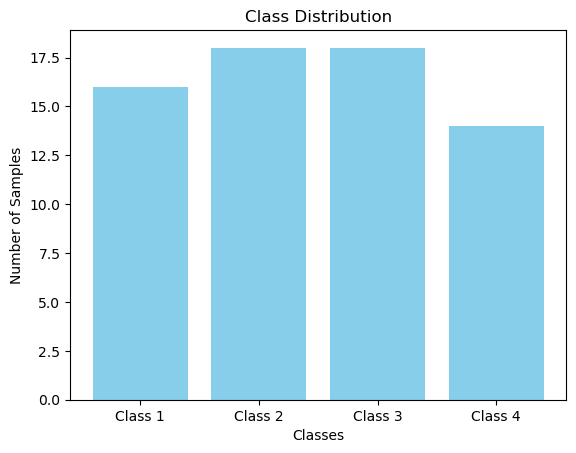

In [5]:
import matplotlib.pyplot as plt

# 四個類別的樣本數量
class_samples = [16, 18, 18, 14]
# 四個類別的標籤
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

# 繪製直方圖
plt.bar(class_labels, class_samples, color='skyblue')

# 添加標題和標籤
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')

# 顯示圖形
plt.show()


## A. Data Loading and Preprocessing

In [3]:
# ImageFolder

from torchvision.datasets import ImageFolder
from transformers import ViTImageProcessor
from sklearn.model_selection import train_test_split

root_dir = "C:\\Users\\AnnaChen\\Python\\DL\\nthu\\hw3\\bottle\\test"
dataset = ImageFolder(root = root_dir)
# print(dataset.class_to_idx)

# processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224") # transform of ViT
# a = processor(images = train_set_before[i][0], return_tensors = "pt")
# print(a["pixel_values"][0].shape)

train_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

# train_transforms = transforms.Compose(
#     [
#         transforms.CenterCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
#     ]
# )

val_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
    ]
)

train_set_before, valid_set_before = train_test_split(dataset, test_size = 0.2, random_state = 401)
batch_size = 36

train_set = []
for i in range(len(train_set_before)):
    totuple = (train_transforms(train_set_before[i][0]), train_set_before[i][1])
    train_set.append(totuple)

valid_set = []
for i in range(len(valid_set_before)):
    totuple = (val_transforms(valid_set_before[i][0]), valid_set_before[i][1])
    valid_set.append(totuple)

trainloader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
validloader = DataLoader(valid_set, batch_size = batch_size, shuffle = False, num_workers = 2)

In [4]:
L_train = [0, 0, 0, 0]
for i in range(len(train_set_before)):
    x = train_set_before[i][1]
    L_train[x] += 1
print(L_train) # [16, 18, 18, 14]

[16, 18, 18, 14]


In [6]:
L_valid = [0, 0, 0, 0]
for i in range(len(valid_set_before)):
    x = valid_set_before[i][1]
    L_valid[x] += 1
print(L_valid) # [4, 4, 3, 6]

[4, 4, 3, 6]


In [12]:
print(dataset.class_to_idx)

{'broken_large': 0, 'broken_small': 1, 'contamination': 2, 'good': 3}


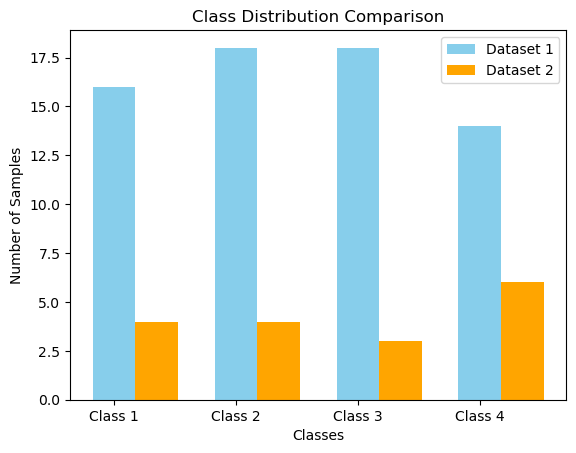

In [7]:
import matplotlib.pyplot as plt

# 四個類別的標籤
class_labels = ['broken_large', 'broken_small', 'contamination', 'good']

# 繪製兩個資料集的直方圖
bar_width = 0.35
plt.bar(class_labels, L_train, color = 'skyblue', width = bar_width, label = 'Training set')
plt.bar([x + bar_width for x in range(len(class_labels))], L_valid, color = 'orange', width = bar_width, label = 'Validation set')

# 添加標題和標籤
plt.title('Distribution of training and test data')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.legend()

# 顯示圖形
plt.show()

## B. Defining Neural Networks

In [4]:
from torchvision import models

model = models.resnet50(weights = 'IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 4

# change # of class from 1000 into 8 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'param name: {name}, shape: {param.shape}')

param name: fc.weight, shape: torch.Size([4, 2048])
param name: fc.bias, shape: torch.Size([4])


In [4]:
from transformers import ViTForImageClassification

model_name = "google/vit-base-patch16-224"    # 定义模型名称或模型的具体路径
model = ViTForImageClassification.from_pretrained(model_name)    # 使用 ViTForImageClassification 加载预训练模型

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features
num_class = 4

# change # of class from 1000 into 8 in the last layer
model.classifier = nn.Linear(in_features = in_features, out_features = num_class)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'param name: {name}, shape: {param.shape}')

param name: classifier.weight, shape: torch.Size([4, 768])
param name: classifier.bias, shape: torch.Size([4])


## C. Training the Neural Network

In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)
model.to(device)

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(trainloader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size = 10, gamma = 0.1)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for i, (images, labels) in enumerate(trainloader):

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        logits = outputs.logits
        labels = labels.long()

        # loss = criterion(outputs, labels)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # train_predicted = outputs.argmax(-1)
        train_predicted = torch.argmax(logits, dim = 1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(trainloader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validloader:

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits
            labels = labels.long()

            # loss = criterion(outputs, labels)
            loss = criterion(logits, labels)
            total_val_loss += loss.item()

            # predicted = outputs.argmax(-1)
            predicted = torch.argmax(logits, dim = 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(validloader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    #if (epoch+1) % 10 == 0: 
    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 1.3833, Train acc: 30.30%, Val loss: 1.2507, Val acc: 29.41%, Best Val loss: 1.2507 Best Val acc: 29.41%
Epoch 2/50, Train loss: 1.2170, Train acc: 43.94%, Val loss: 1.1651, Val acc: 35.29%, Best Val loss: 1.1651 Best Val acc: 35.29%
Epoch 3/50, Train loss: 1.0968, Train acc: 54.55%, Val loss: 1.0989, Val acc: 52.94%, Best Val loss: 1.0989 Best Val acc: 52.94%
Epoch 4/50, Train loss: 0.9974, Train acc: 69.70%, Val loss: 1.0579, Val acc: 52.94%, Best Val loss: 1.0579 Best Val acc: 52.94%
Epoch 5/50, Train loss: 0.9058, Train acc: 78.79%, Val loss: 1.0138, Val acc: 58.82%, Best Val loss: 1.0138 Best Val acc: 58.82%
Epoch 6/50, Train loss: 0.8299, Train acc: 80.30%, Val loss: 0.9566, Val acc: 58.82%, Best Val loss: 0.9566 Best Val acc: 58.82%
Epoch 7/50, Train loss: 0.7669, Train acc: 84.85%, Val loss: 0.8783, Val acc: 52.94%, Best Val loss: 0.8783 Best Val acc: 58.82%
Epoch 8/50, Train loss: 0.7082, Train acc: 90.91%, Val loss: 0.7942, Val acc: 70.59%, Best Val lo

### Visualizing model performance

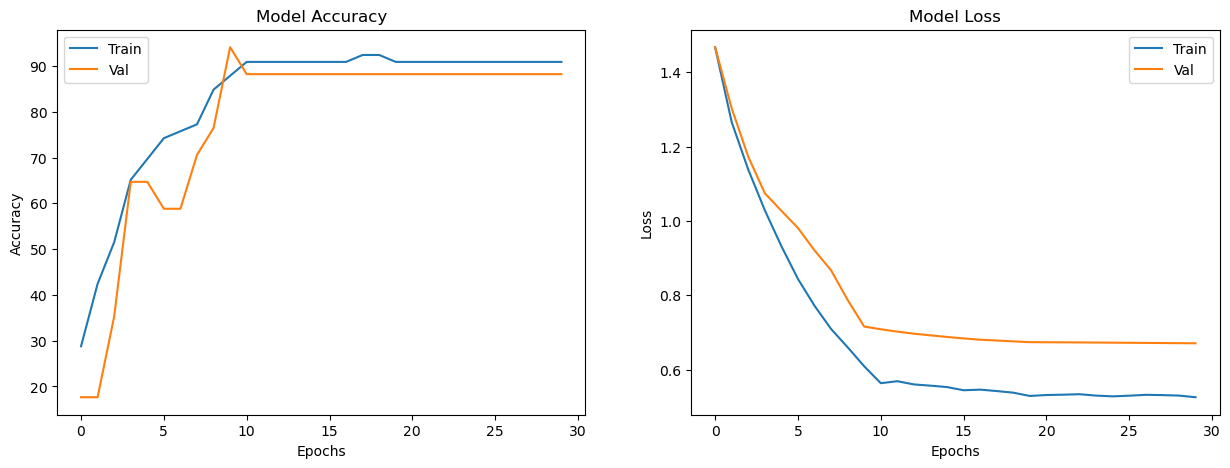

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [9]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in validloader:

        images = images.cuda()
        images = images

        labels = labels.to(device)
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([3, 0, 1, 2, 2, 1, 1, 2, 1, 1, 3, 3, 2, 1, 3, 1, 3], device='cuda:0')
tensor([3, 0, 1, 2, 1, 2, 1, 0, 3, 0, 3, 3, 0, 2, 3, 1, 3], device='cuda:0')
Test accuracy is 58.8235294117647%
